In [2]:
# import system modules
import sys
import os
import gc
import argparse

# import standard numerical modules
import numpy as np
import math

import matplotlib.pyplot as plt

# import machine learning modules
import tensorflow as tf
import keras.backend as K

sys.path.append('../')
import DCTR


2024-09-17 14:57:37.843156: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /nfs/dust/cms/user/puschman/tf_venv/lib64/cudnn:/cvmfs/sft.cern.ch/lcg/releases/cuda/12.4-4899e/x86_64-el9-gcc11-opt/lib64:/cvmfs/sft.cern.ch/lcg/releases/LCG_106_cuda/cuda/12.4/x86_64-el9-gcc11-opt/lib64/cmake:/cvmfs/sft.cern.ch/lcg/releases/LCG_106_cuda/cuda/12.4/x86_64-el9-gcc11-opt/lib64/stubs:/cvmfs/sft.cern.ch/lcg/releases/LCG_106_cuda/cuda/12.4/x86_64-el9-gcc11-opt/lib64:/cvmfs/sft.cern.ch/lcg/releases/LCG_106_cuda/cudnn/9.1.1.17/x86_64-el9-gcc11-opt/lib64:/cvmfs/sft.cern.ch/lcg/releases/LCG_106_cuda/cudnn/9.1.1.17/x86_64-el9-gcc11-opt/lib:/cvmfs/sft.cern.ch/lcg/releases/gcc/11.3.0-de683/x86_64-el9/lib:/cvmfs/sft.cern.ch/lcg/releases/gcc/11.3.0-de683/x86_64-el9/lib64:/cvmfs/sft.cern.ch/lcg/releases/binutils/2.40-acaab/x86_64-el9/lib:/n

In [5]:
!jupyter nbconvert --to python 'DCTR_jets_notebook_20240915_b-filtered_my-samples.ipynb'



usage: ipython [-h] [--debug] [--show-config] [--show-config-json] [--quiet]
               [--init] [--autoindent] [--no-autoindent] [--automagic]
               [--no-automagic] [--pdb] [--no-pdb] [--pprint] [--no-pprint]
               [--color-info] [--no-color-info] [--ignore-cwd]
               [--no-ignore-cwd] [--nosep] [--autoedit-syntax]
               [--no-autoedit-syntax] [--simple-prompt] [--no-simple-prompt]
               [--banner] [--no-banner] [--confirm-exit] [--no-confirm-exit]
               [--term-title] [--no-term-title] [--classic] [--quick] [-i]
               [--log-level TerminalIPythonApp.log_level]
               [--profile-dir ProfileDir.location]
               [--profile TerminalIPythonApp.profile]
               [--ipython-dir TerminalIPythonApp.ipython_dir]
               [--config TerminalIPythonApp.extra_config_file]
               [--autocall TerminalInteractiveShell.autocall]
               [--colors TerminalInteractiveShell.colors]
             

# Process Data

In [7]:
data_dir = '../../Data'


In [8]:

num_events = 9686913 # = num MiNNLO events


## hvq dielptonic


In [9]:
# dileptonic hvq has 1M events per LHE

X0 = []
X0_nJets = []
X0_jet = []
X0_b_jets = []
X0_b_quarks = []

data_dir_hvq = f'{data_dir}/POWHEG_hvq/dileptonic/20240917'

# skipped_files = [1, 8, 10, 12, 14, 18] # due to corrupted files

for i in range(1, 1001):
    X0.extend(
        np.load(f'{data_dir_hvq}/converted_lhe_hvq_dileptonic_10K_{i}_b-filtered.npy')
    )

    X0_nJets.extend(
        np.load(f'{data_dir_hvq}/jet_multiplicity_hvq_dileptonic_10K_{i}_b-filtered.npy')
    )
    X0_jet.extend(
        np.load(f'{data_dir_hvq}/jet_4vectors_hvq_dileptonic_10K_{i}_b-filtered.npy')
    )
    X0_b_jets.extend(
        np.load(f'{data_dir_hvq}/b_jets_hvq_dileptonic_10K_{i}_b-filtered.npy')
    )
    X0_b_quarks.extend(
        np.load(f'{data_dir_hvq}/b_quarks_hvq_dileptonic_10K_{i}_b-filtered.npy')
    )
    if i % 50 == 0:
        print(f'read {i} files')

X0 = np.array(X0)
print(X0.shape)

# nrm data and save to disk (only needed to run once)

nrm_array_dir = f'{data_dir}/POWHEG_hvq/showered/'
nrm_array = np.load(f'{nrm_array_dir}/norm_array_lhe_01.npy')
X0_nrm, _ = DCTR.normalize_data(X0.copy(), nrm_array)
X0_nrm = np.array(X0_nrm)
np.save(f'{data_dir_hvq}/normed_lhe_hvq_dileptonic_10K_1-1000_b-filtered.npy', X0_nrm)

X0       = np.array(X0[:num_events])

X0_nJets = np.array(X0_nJets[:num_events])
X0_jet   = np.array(X0_jet[:num_events])

X0_b_jets    = np.array(X0_b_jets[:num_events])
X0_b_quarks  = np.array(X0_b_quarks[:num_events])

X0_nrm = np.load(f'{data_dir_hvq}/normed_lhe_hvq_dileptonic_10K_1-1000_b-filtered.npy')[:num_events]
X0_wgt = X0_nJets[:,1]

print(X0.shape)
print(X0_nrm.shape)
print(X0_nJets.shape)
print(X0_jet.shape)


read 50 files


KeyboardInterrupt: 

## MiNNLO

In [5]:
gc.collect()


495

In [10]:
# MiNNLO has 10k events per lhe

data_dir_minnlo = f'{data_dir}/MiNNLO/showered/20240917'

X1 = []
X1_nJets = []
X1_jet = []

X1_b_jets = []
X1_b_quarks = []


# skipped_files = [106, 126, 210]


for i in range(1, 1001):
    X1.extend(
        np.load(f'{data_dir_minnlo}/converted_lhe_MiNNLO_10K_{i}_b-filtered.npy')
    )
    X1_nJets.extend(
        np.load(f'{data_dir_minnlo}/jet_multiplicity_MiNNLO_10K_{i}_b-filtered.npy')
    )
    X1_jet.extend(
        np.load(f'{data_dir_minnlo}/jet_4vectors_MiNNLO_10K_{i}_b-filtered.npy')
    )
    X1_b_jets.extend(
        np.load(f'{data_dir_minnlo}/b_jets_MiNNLO_10K_{i}_b-filtered.npy')
    )
    X1_b_quarks.extend(
        np.load(f'{data_dir_minnlo}/b_quarks_MiNNLO_10K_{i}_b-filtered.npy')
    )
    if i % 50 == 0:
        print(f'read {i} files')

X1 = np.array(X1)
print(X1.shape)

# nrm data and save to disk (only needed to run once)

nrm_array_dir = f'{data_dir}/POWHEG_hvq/showered/'
nrm_array = np.load(f'{nrm_array_dir}/norm_array_lhe_01.npy')
X1_nrm, _ = DCTR.normalize_data(X1.copy(), nrm_array)
np.save(f'{data_dir_minnlo}/normed_lhe_MiNNLO_10K_1-1000_b-filtered.npy', X1_nrm)

X1       = np.array(X1[:num_events])
print(X1.shape)


X1_nJets = np.array(X1_nJets[:num_events])
X1_jet   = np.array(X1_jet[:num_events])

X1_b_jets   = np.array(X1_b_jets[:num_events])
X1_b_quarks = np.array(X1_b_quarks[:num_events])

X1_nrm = np.load(f'{data_dir_minnlo}/normed_lhe_MiNNLO_10K_1-1000_b-filtered.npy')[:num_events]
X1_wgt = X1_nJets[:, 1]

print(X1.shape)
print(X1_nrm.shape)
print(X1_nJets.shape)
print(X1_jet.shape)



read 50 files


KeyboardInterrupt: 

In [7]:
gc.collect()


902

In [8]:
print(X0.shape)
print(X0_nrm.shape)
print(X0_nJets.shape)
print(X0_jet.shape)

print(X0_b_jets.shape)
print(X0_b_quarks.shape)


print(X1.shape)
print(X1_nrm.shape)
print(X1_nJets.shape)
print(X1_jet.shape)

print(X1_b_jets.shape)
print(X1_b_quarks.shape)


(9686913, 3, 9)
(9686913, 3, 9)
(9686913, 2)
(9686913, 20, 6)
(9686913, 2, 6)
(9686913, 2, 7)
(9686913, 3, 9)
(9686913, 3, 9)
(9686913, 2)
(9686913, 20, 6)
(9686913, 2, 6)
(9686913, 2, 7)


# prepare datasets

In [9]:
# delete energy from (normalized) testing dataset, since the neural network was trained without these parameters
X0_nrm = np.delete(X0_nrm, 5, -1) # E
X0_nrm = np.delete(X0_nrm, 4, -1) # eta

# garbage collection after deleting to clear memory asap
print(gc.collect())

print(X0_nrm.shape)
print(X0_nrm[0])


0
(9686913, 3, 7)
[[-0.57342503  1.03563999  0.27997945 -0.35989839  0.          1.
   1.        ]
 [ 0.28320021  0.56527613 -0.31920968  0.23710697  0.6         1.
   1.        ]
 [ 0.18415215  1.2120562   1.31850957  0.71193994 -0.6         1.
   1.        ]]


# compare datasets before reweighting

## hvq vs MiNNLO

In [12]:
print(max(X0_nJets[:,0]))
print(max(X1_nJets[:,0]))


17.0
18.0


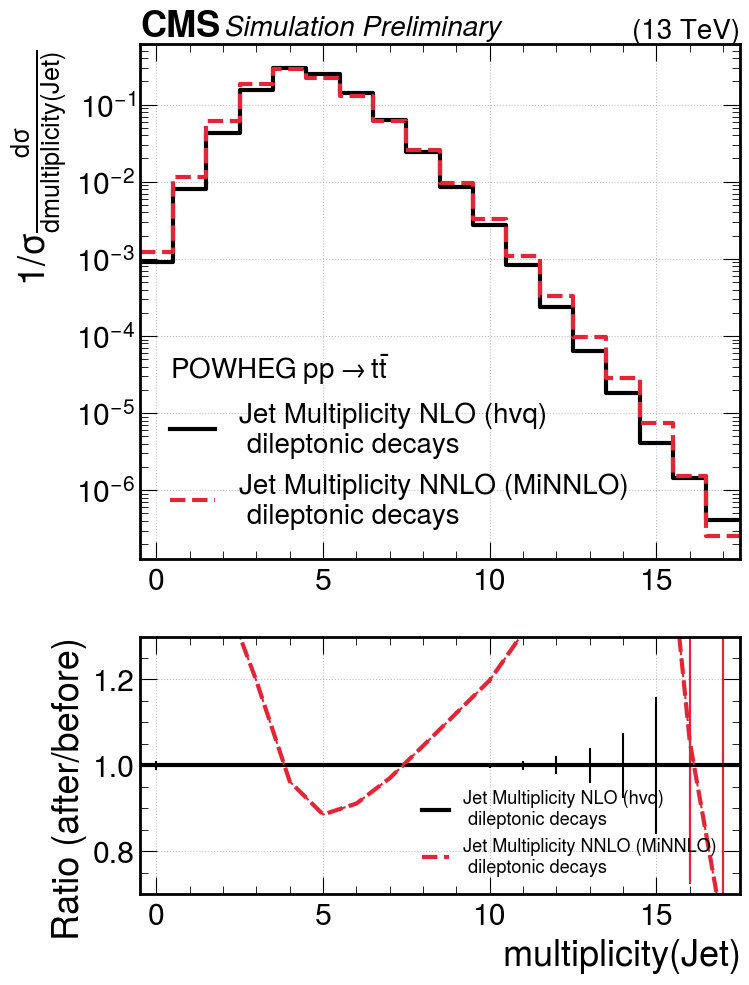

In [13]:
# jet multiplicity

args_multiplicity = [(X0_nJets[:,0], X0_wgt, 'Jet Multiplicity NLO (hvq) \n dileptonic decays'),
                     (X1_nJets[:,0], X1_wgt, 'Jet Multiplicity NNLO (MiNNLO) \n dileptonic decays')]


bins = np.linspace(-0.5, 17.5, 19)

DCTR.plot_ratio_cms_2(args_multiplicity, bins = bins, y_scale = 'log', ratio_ylim=[0.7, 1.3], part_label='Jet', arg_label='multiplicity', unit='', inv_unit='')



# DCTR reweighting


In [10]:
# calculate weights from DCTR trained on showered events
model = '../20240521_showered_new/train_20240523_regular_epochs.tf' # path to previously trained model (in .tf format (folder)) for showered events

dctr_rwgt = []
# calculate rwgt
with tf.device('CPU'):
    dctr_rwgt = DCTR.get_rwgt([model], X0_nrm) # .tf models also include network architecture. get_rwgt() sets up the network for the (list of) models, then calls predict_weights() like in DCTR_notebook_OLD_14-to-13TeV notebook



2024-09-17 13:17:18.703295: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-09-17 13:17:18.704675: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-09-17 13:17:18.706325: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (finn-ThinkPad-T540p): /proc/driver/nvidia/version does not exist
2024-09-17 13:17:18.770121: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-17 13:17:25.620027: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 7749530

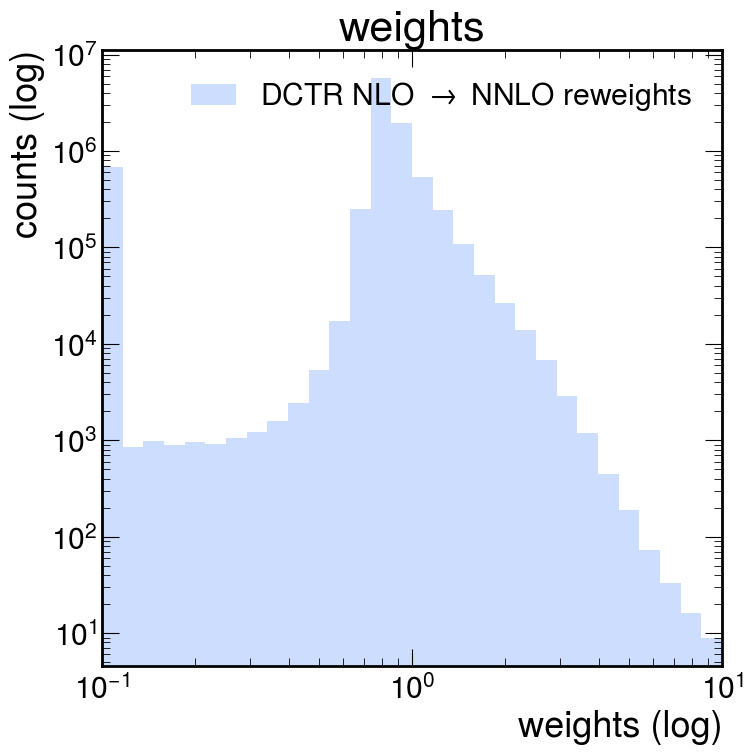

In [11]:
wgts_plot = [(dctr_rwgt[0], r'DCTR NLO $\to$ NNLO reweights')]

DCTR.plot_weights(wgts_plot, start = 0.1, stop = 10)

# apply orginal generator weights to rwgt
dctr_rwgt = np.multiply(dctr_rwgt[0], X0_wgt)



In [12]:
pythia_text=r'$POWHEG \; pp \to  t\bar{t}$ + PYTHIA'


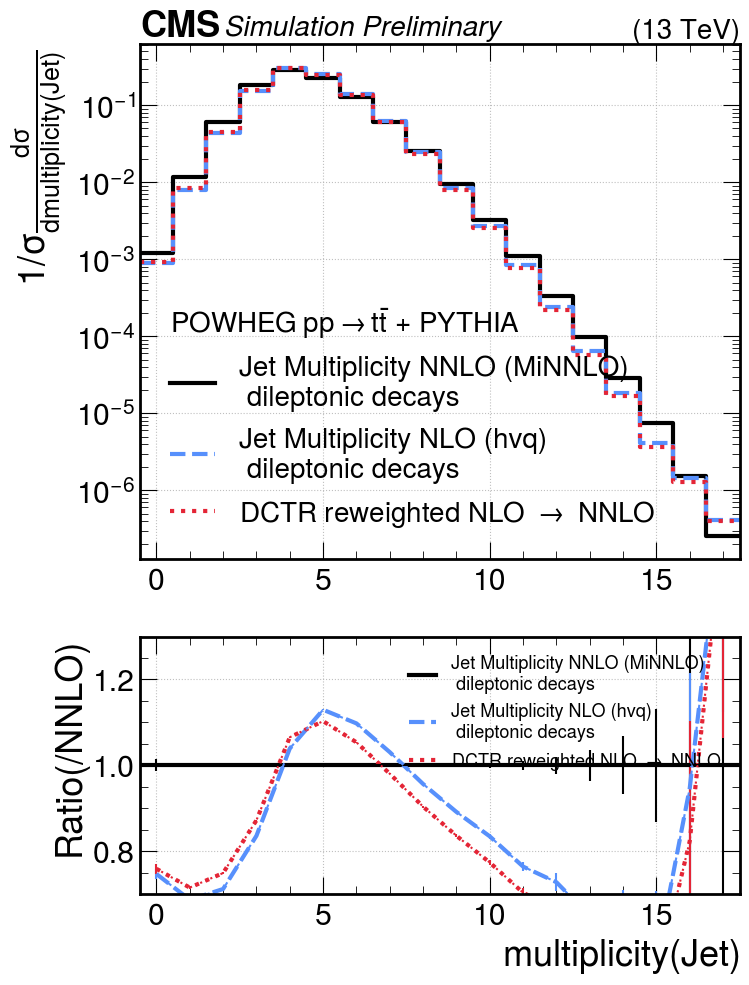

In [13]:
# jet multiplicity

args_multiplicity = [(X1_nJets[:,0], X1_wgt, 'Jet Multiplicity NNLO (MiNNLO) \n dileptonic decays'),
                     (X0_nJets[:,0], X0_wgt, 'Jet Multiplicity NLO (hvq) \n dileptonic decays'),
                     (X0_nJets[:,0], dctr_rwgt, r'DCTR reweighted NLO $\to$ NNLO')]

bins = np.linspace(-0.5, 17.5, 19)
ratio_ylim=[0.7, 1.3]

DCTR.plot_ratio_cms(args_multiplicity, bins = bins, y_scale = 'log', ratio_ylim=ratio_ylim, part_label='Jet', arg_label='multiplicity', unit='', inv_unit='', pythia_text=pythia_text)


In [14]:
hists = np.load('./plots/tt-pair/plot_multiplicity_jet_histograms.npy', allow_pickle=True) # hist data is automatically saved to disk above

[dense_list, uncert_nrm_list, bin_edges] = hists

# print(dense_list)
print(np.sum(dense_list[0]))
print(np.sum(dense_list[1]))
print(np.sum(dense_list[2]))


1.0000002564117356
1.0000004163259482
1.0000004013638109


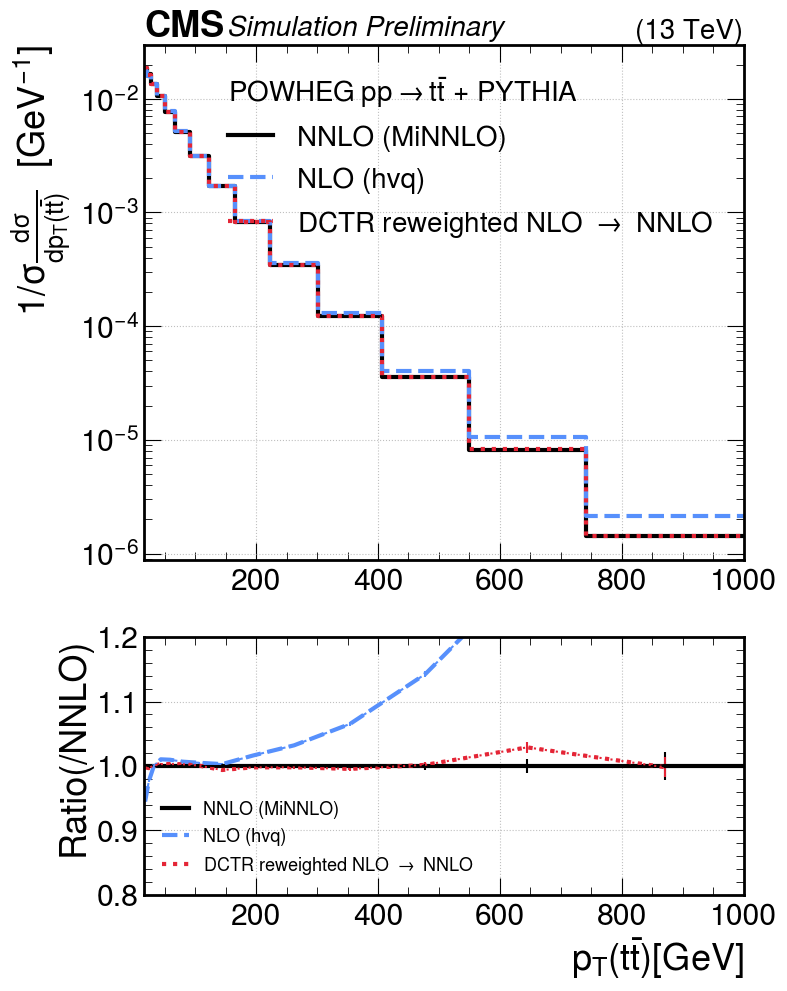

In [15]:
# pT to make sure our regular obs is working

args = [(X1, X1_wgt, 'NNLO (MiNNLO)'),
        (X0, X0_wgt, 'NLO (hvq)'),
        (X0, dctr_rwgt, r'DCTR reweighted NLO $\to$ NNLO')]


bins = np.logspace(np.log10(15), np.log10(1000), 15)

DCTR.plot_ratio_cms(args, bins = bins, y_scale = 'log', ratio_ylim=[0.8, 1.2], pythia_text=pythia_text)


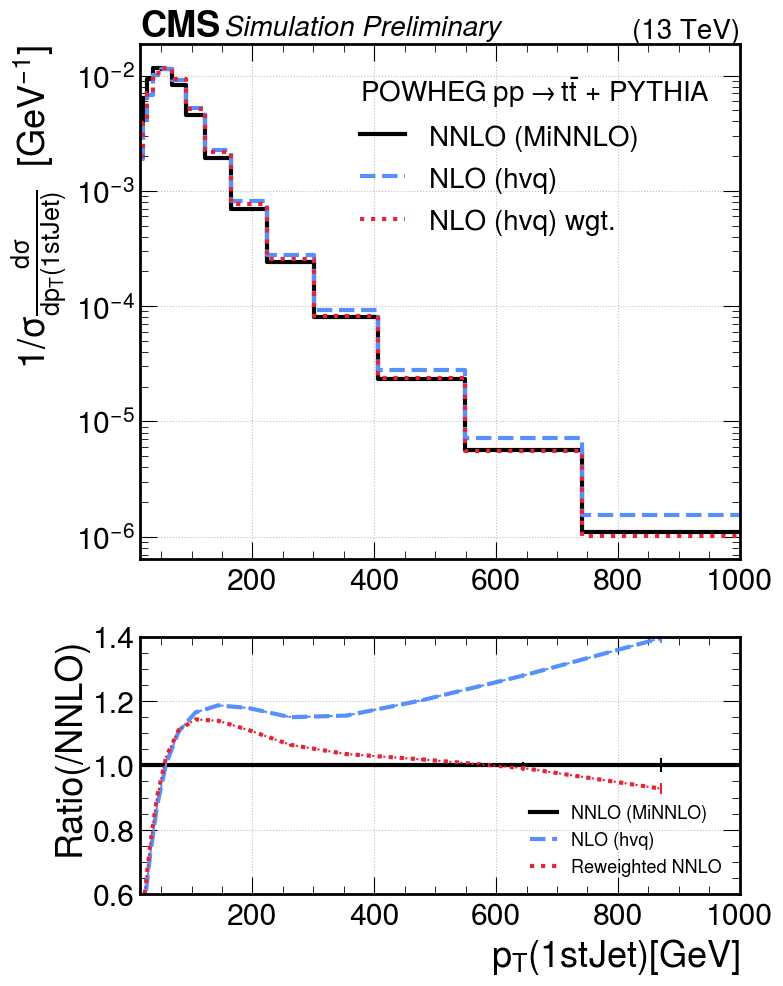

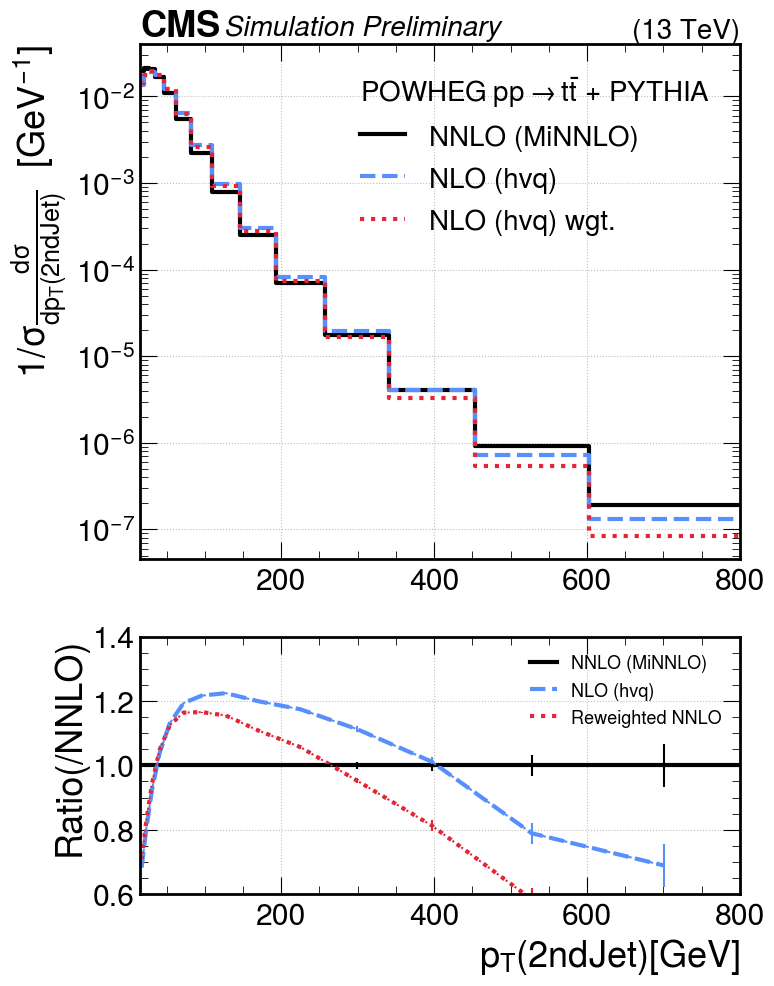

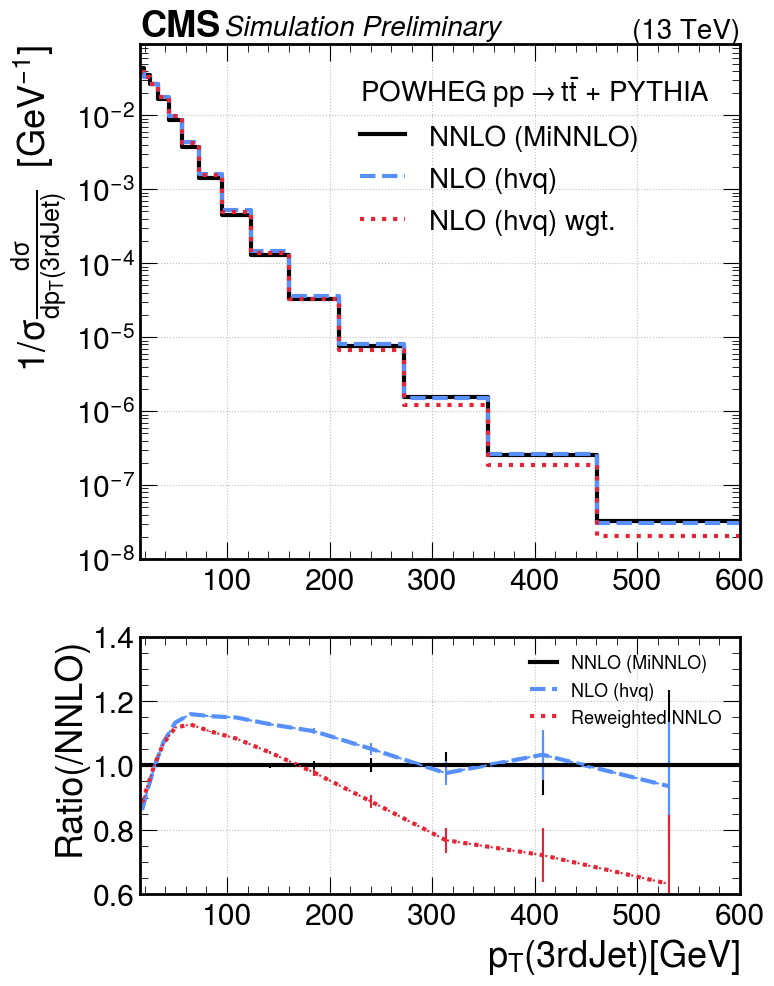

In [16]:
# all jets pT

# 1st jet
log_bins = np.logspace(np.log10(15), np.log10(1000), 15)
args_jet_0 = [(X1_jet[:, 0, 0], X1_wgt, 'NNLO (MiNNLO)'),
              (X0_jet[:, 0, 0], X0_wgt, 'NLO (hvq)'),
              (X0_jet[:, 0, 0], dctr_rwgt, 'NLO (hvq) wgt.')]

DCTR.plot_ratio_cms(args_jet_0, y_scale = 'log', part_label='1st Jet', ratio_ylim=(0.6, 1.4), bins = log_bins, pythia_text=pythia_text, save_prefix = 'with_b_jets')

log_bins = np.logspace(np.log10(15), np.log10(800), 15)
args_jet_1 = [(X1_jet[:, 1, 0], X1_wgt, 'NNLO (MiNNLO)'),
              (X0_jet[:, 1, 0], X0_wgt, 'NLO (hvq)'),
              (X0_jet[:, 1, 0], dctr_rwgt, 'NLO (hvq) wgt.')]

DCTR.plot_ratio_cms(args_jet_1, y_scale = 'log', part_label='2nd Jet', ratio_ylim=(0.6, 1.4), bins = log_bins, pythia_text=pythia_text, save_prefix = 'with_b_jets')

log_bins = np.logspace(np.log10(15), np.log10(600), 15)
args_jet_2 = [(X1_jet[:, 2, 0], X1_wgt, 'NNLO (MiNNLO)'),
              (X0_jet[:, 2, 0], X0_wgt, 'NLO (hvq)'),
              (X0_jet[:, 2, 0], dctr_rwgt, 'NLO (hvq) wgt.')]

DCTR.plot_ratio_cms(args_jet_2, y_scale = 'log', part_label='3rd Jet', ratio_ylim=(0.6, 1.4), bins = log_bins, pythia_text=pythia_text, save_prefix = 'with_b_jets')



In [18]:
X0_jet.shape

(9686913, 20, 6)

In [ ]:
# LOAD W Bosons, leptons and no_b_jets from disk

X0_jets_no_b = []
X1_jets_no_b = []

X0_W = []
X0_lep = []

X1_W = []
X1_lep = []


for i in range(1, 1001):
    X0_W.extend(
        np.load(f'{data_dir_hvq}/W_Bosons_array_hvq_dileptonic_10K_{i}_b-filtered.npy')
    )
    X0_lep.extend(
        np.load(f'{data_dir_hvq}/leptons_array_hvq_dileptonic_10K_{i}_b-filtered.npy')
    )
    X0_jets_no_b.extend(
        np.load(f'{data_dir_hvq}/jet_4vectors_no_b_hvq_dileptonic_10K_{i}_b-filtered.npy')
    )


    X1_W.extend(
        np.load(f'{data_dir_minnlo}/W_Bosons_array_MiNNLO_10K_{i}_b-filtered.npy')
    )
    X1_lep.extend(
        np.load(f'{data_dir_minnlo}/leptons_array_MiNNLO_10K_{i}_b-filtered.npy')
    )
    X0_jets_no_b.extend(
        np.load(f'{data_dir_minnlo}/jet_4vectors_no_b_MiNNLO_10K_{i}_b-filtered.npy')
    )
    if i % 50 == 0:
        print(f'read {i} files')

X0_W   = np.array(X0_W[:num_events])
X0_lep = np.array(X0_lep[:num_events])

X1_W   = np.array(X1_W[:num_events])
X1_lep = np.array(X1_lep[:num_events])

X0_jets_no_b = np.array(X0_jets_no_b[:num_events])
X1_jets_no_b = np.array(X1_jets_no_b[:num_events])


print(X0_W.shape)
print(X0_lep.shape)
print(X0_jets_no_b.shape)

print(X1_W.shape)
print(X1_lep.shape)
print(X1_jets_no_b.shape)


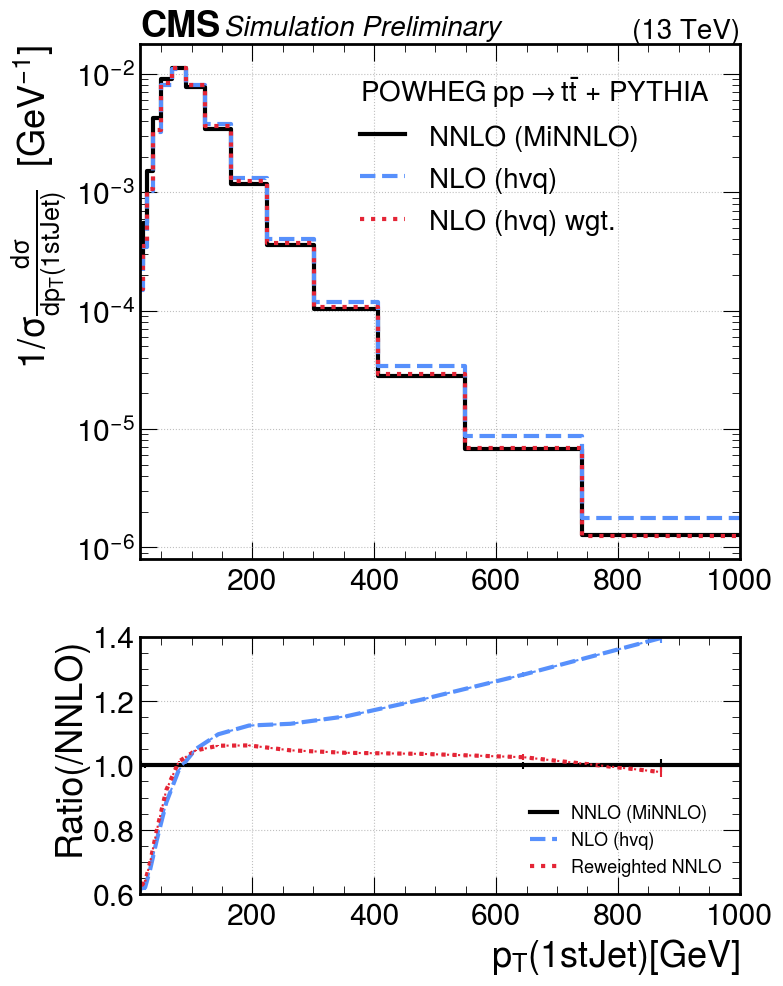

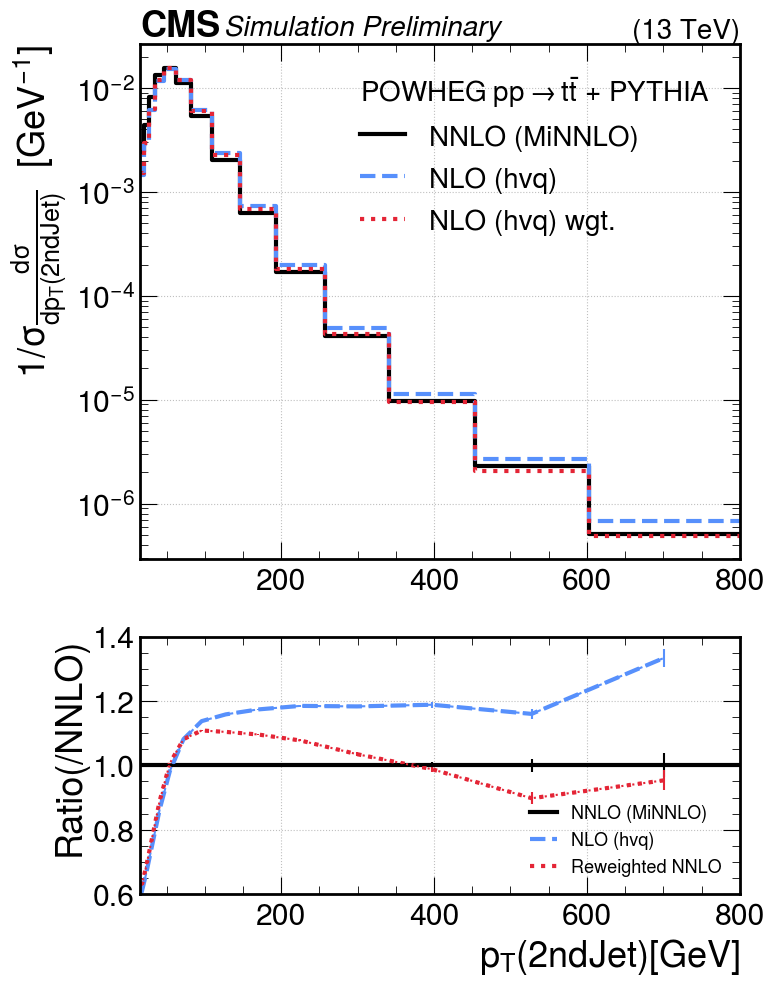

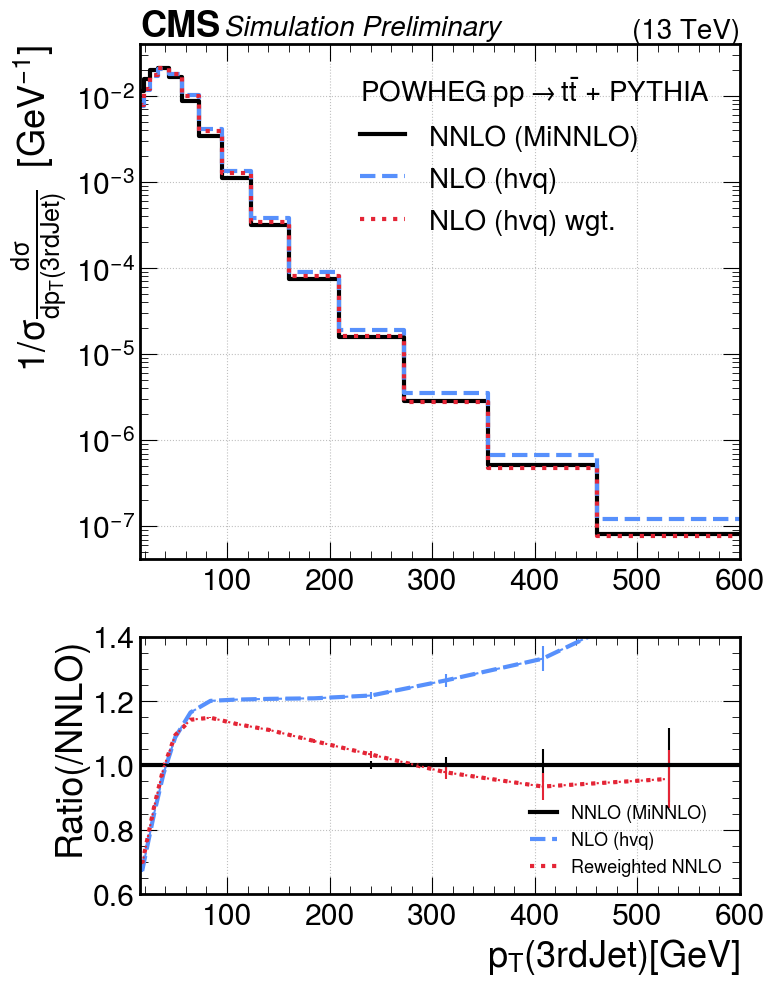

In [20]:
# jet pT (incl_b_jets)

# 1st jet
log_bins = np.logspace(np.log10(15), np.log10(1000), 15)
args_jet_0 = [(X1_jet_incl_b[:, 0, 0], X1_wgt, 'NNLO (MiNNLO)'),
              (X0_jet_incl_b[:, 0, 0], X0_wgt, 'NLO (hvq)'),
              (X0_jet_incl_b[:, 0, 0], dctr_rwgt, 'NLO (hvq) wgt.')]

DCTR.plot_ratio_cms(args_jet_0, y_scale = 'log', part_label='1st Jet', ratio_ylim=(0.6, 1.4), bins = log_bins, pythia_text=pythia_text, save_prefix = 'no_b_jets')

log_bins = np.logspace(np.log10(15), np.log10(800), 15)
args_jet_1 = [(X1_jet_incl_b[:, 1, 0], X1_wgt, 'NNLO (MiNNLO)'),
              (X0_jet_incl_b[:, 1, 0], X0_wgt, 'NLO (hvq)'),
              (X0_jet_incl_b[:, 1, 0], dctr_rwgt, 'NLO (hvq) wgt.')]

DCTR.plot_ratio_cms(args_jet_1, y_scale = 'log', part_label='2nd Jet', ratio_ylim=(0.6, 1.4), bins = log_bins, pythia_text=pythia_text, save_prefix = 'no_b_jets')

log_bins = np.logspace(np.log10(15), np.log10(600), 15)
args_jet_2 = [(X1_jet_incl_b[:, 2, 0], X1_wgt, 'NNLO (MiNNLO)'),
              (X0_jet_incl_b[:, 2, 0], X0_wgt, 'NLO (hvq)'),
              (X0_jet_incl_b[:, 2, 0], dctr_rwgt, 'NLO (hvq) wgt.')]

DCTR.plot_ratio_cms(args_jet_2, y_scale = 'log', part_label='3rd Jet', ratio_ylim=(0.6, 1.4), bins = log_bins, pythia_text=pythia_text, save_prefix = 'no_b_jets')



In [21]:
# b jets
(X0_b_jets.shape)
print(X1_b_jets.shape)

# concat first and second b_jets
X0_b_jets_pt_concat = np.concatenate((X0_b_jets[:,0, 0], X0_b_jets[:,1, 0]))
X1_b_jets_pt_concat = np.concatenate((X1_b_jets[:,0, 0], X1_b_jets[:,1, 0]))

# concat wgt with itself, to have correct wgt for concat b jet array
X0_wgt_concat = np.concatenate((X0_wgt, X0_wgt))
X1_wgt_concat = np.concatenate((X1_wgt, X1_wgt))

dctr_rwgt_concat = np.concatenate((dctr_rwgt, dctr_rwgt))

print(X0_b_jets_pt_concat.shape)
print(X1_b_jets_pt_concat.shape)

print(X0_wgt_concat.shape)
print(X1_wgt_concat.shape)

print(dctr_rwgt_concat.shape)

(9686913, 2, 6)


(19373826,)
(19373826,)
(19373826,)
(19373826,)
(19373826,)


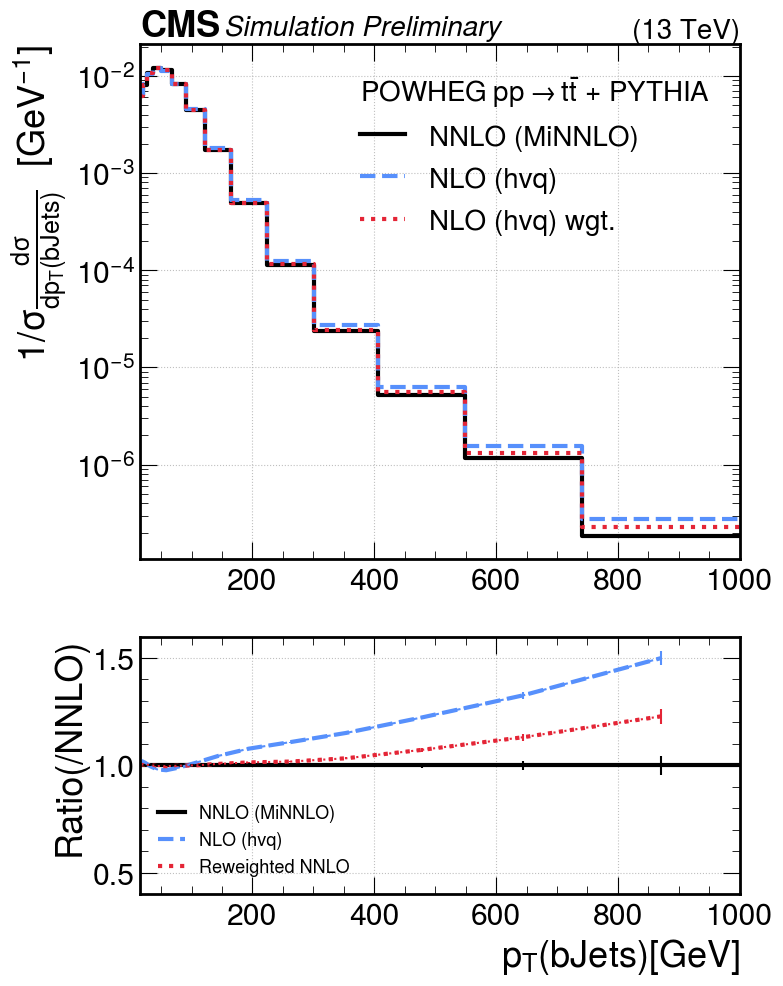

In [22]:
# b-jet pT

log_bins = np.logspace(np.log10(15), np.log10(1000), 15)
args_jet_0 = [(X1_b_jets_pt_concat, X1_wgt_concat, 'NNLO (MiNNLO)'),
              (X0_b_jets_pt_concat, X0_wgt_concat, 'NLO (hvq)'),
              (X0_b_jets_pt_concat, dctr_rwgt_concat, 'NLO (hvq) wgt.')]

DCTR.plot_ratio_cms(args_jet_0, y_scale = 'log', part_label='b Jets', ratio_ylim=(0.4, 1.6), bins = log_bins, pythia_text=pythia_text)


In [23]:
# LOAD W Bosons and leptons from disk

# dileptonic hvq has 1M events per LHE

X0_W = []
X0_lep = []

X1_W = []
X1_lep = []

for i in range(1, 1001):
    X0_W.extend(
        np.load(f'{data_dir_hvq}/W_Bosons_array_hvq_dileptonic_10K_{i}_b-filtered.npy')
    )
    X0_lep.extend(
        np.load(f'{data_dir_hvq}/leptons_array_hvq_dileptonic_10K_{i}_b-filtered.npy')
    )


    X1_W.extend(
        np.load(f'{data_dir_minnlo}/W_Bosons_array_MiNNLO_10K_{i}_b-filtered.npy')
    )
    X1_lep.extend(
        np.load(f'{data_dir_minnlo}/leptons_array_MiNNLO_10K_{i}_b-filtered.npy')
    )
    if i % 50 == 0:
        print(f'read {i} files')

X0_W   = np.array(X0_W[:num_events])
X0_lep = np.array(X0_lep[:num_events])

X1_W   = np.array(X1_W[:num_events])
X1_lep = np.array(X1_lep[:num_events])


print(X0_W.shape)
print(X0_lep.shape)

print(X1_W.shape)
print(X1_lep.shape)


read 50 files
read 100 files
read 150 files
read 200 files
read 250 files
read 300 files
read 350 files
read 400 files
read 450 files
read 500 files
read 550 files
read 600 files
read 650 files
read 700 files
read 750 files
read 800 files
read 850 files
read 900 files
read 950 files
read 1000 files
(9686913, 2, 7)
(9686913, 2, 7)
(9686913, 2, 7)
(9686913, 2, 7)


In [24]:
# concat W Bosons and leptons (like the b jets above)

# W
X0_W_concat = np.concatenate((X0_W[:,0, 0], X0_W[:,1, 0])) # only pt, to save on memory
X1_W_concat = np.concatenate((X1_W[:,0, 0], X1_W[:,1, 0]))

print(X0_W_concat.shape)
print(X1_W_concat.shape)


# lepton
X1_lep_concat = np.concatenate((X0_lep[:,0, 0], X0_lep[:,1, 0])) # only pt, to save on memory
X1_lep_concat = np.concatenate((X1_lep[:,0, 0], X1_lep[:,1, 0]))

print(X0_lep_concat.shape)
print(X1_lep_concat.shape)


(19373826,)
(19373826,)


NameError: name 'X0_lep_concat' is not defined

In [ ]:
# W pT

log_bins = np.logspace(np.log10(15), np.log10(1000), 15)
args_jet_0 = [(X1_W_concat, X1_wgt_concat, 'NNLO (MiNNLO)'),
              (X0_W_concat, X0_wgt_concat, 'NLO (hvq)'),
              (X0_W_concat, dctr_rwgt_concat, 'NLO (hvq) wgt.')]

DCTR.plot_ratio_cms(args_jet_0, y_scale = 'log', part_label='W', ratio_ylim=(0.4, 1.6), bins = log_bins, pythia_text=pythia_text)


In [ ]:
# lepton pT

log_bins = np.logspace(np.log10(15), np.log10(1000), 15)
args_jet_0 = [(X1_lep_concat, X1_wgt_concat, 'NNLO (MiNNLO)'),
              (X0_lep_concat, X0_wgt_concat, 'NLO (hvq)'),
              (X0_lep_concat, dctr_rwgt_concat, 'NLO (hvq) wgt.')]

DCTR.plot_ratio_cms(args_jet_0, y_scale = 'log', part_label='leptons', ratio_ylim=(0.4, 1.6), bins = log_bins, pythia_text=pythia_text)


np.shape(X0_jet_pt_sums) = (9686913,)
np.shape(X1_jet_pt_sums) = (9686913,)


/media/finn/Temp/DCTR_Paper/DCTR_FP/20240903_jets_FINAL_FSR-MPI-HadronLevel_all/../DCTR.py:1282: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


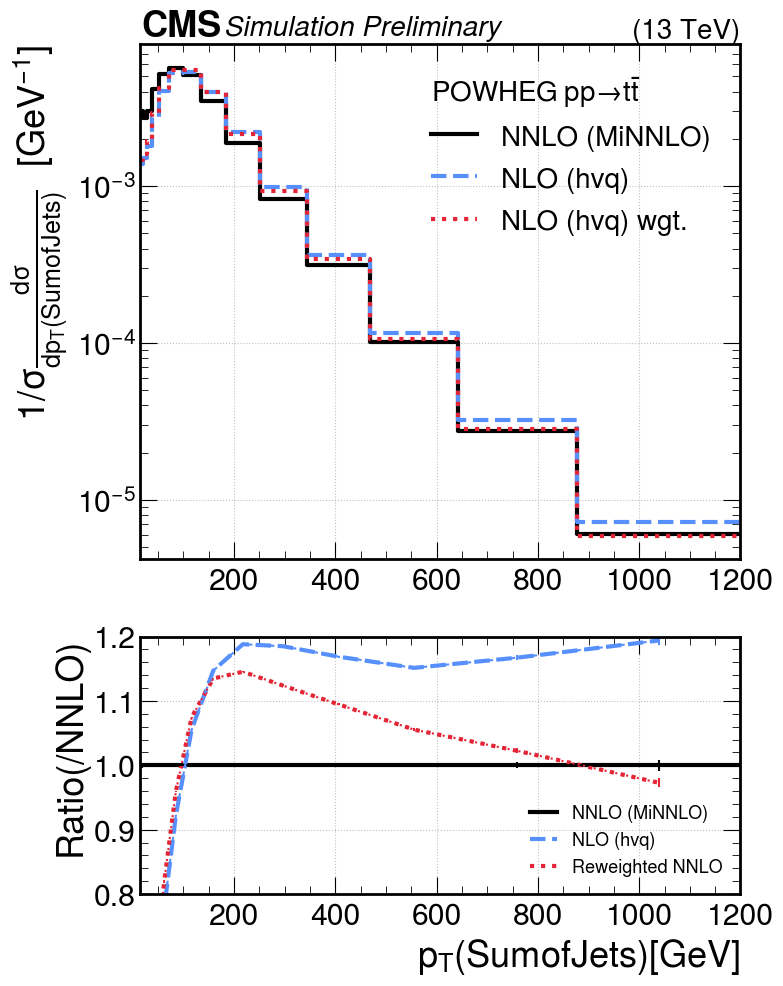

In [ ]:
# sum of jet (no b jets) pt per event

X0_jet_pt_sums = []
for event in X0_no_b_jet:
    X0_jet_pt_sums.append(np.sum(event[:,0]))

X1_jet_pt_sums = []
for event in X1_no_b_jet:
    X1_jet_pt_sums.append(np.sum(event[:,0]))

    
print(f'{np.shape(X0_jet_pt_sums) = }')
print(f'{np.shape(X1_jet_pt_sums) = }')


args_jet_sum = [(np.array(X1_jet_pt_sums), X1_wgt, 'NNLO (MiNNLO)'),
                (np.array(X0_jet_pt_sums), X0_wgt, 'NLO (hvq)'),
                (np.array(X0_jet_pt_sums), dctr_rwgt, 'NLO (hvq) wgt.')]

log_bins = np.logspace(np.log10(15), np.log10(1200), 15)
lin_bins = np.linspace(15, 800, 15)

DCTR.plot_ratio_cms(args_jet_sum, bins = log_bins, y_scale = 'log', part_label='Sum of Jets', ratio_ylim=(0.8, 1.2))



np.shape(X0_jet_pt_sums) = (9686913,)
np.shape(X1_jet_pt_sums) = (9686913,)


/media/finn/Temp/DCTR_Paper/DCTR_FP/20240903_jets_FINAL_FSR-MPI-HadronLevel_all/../DCTR.py:1282: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


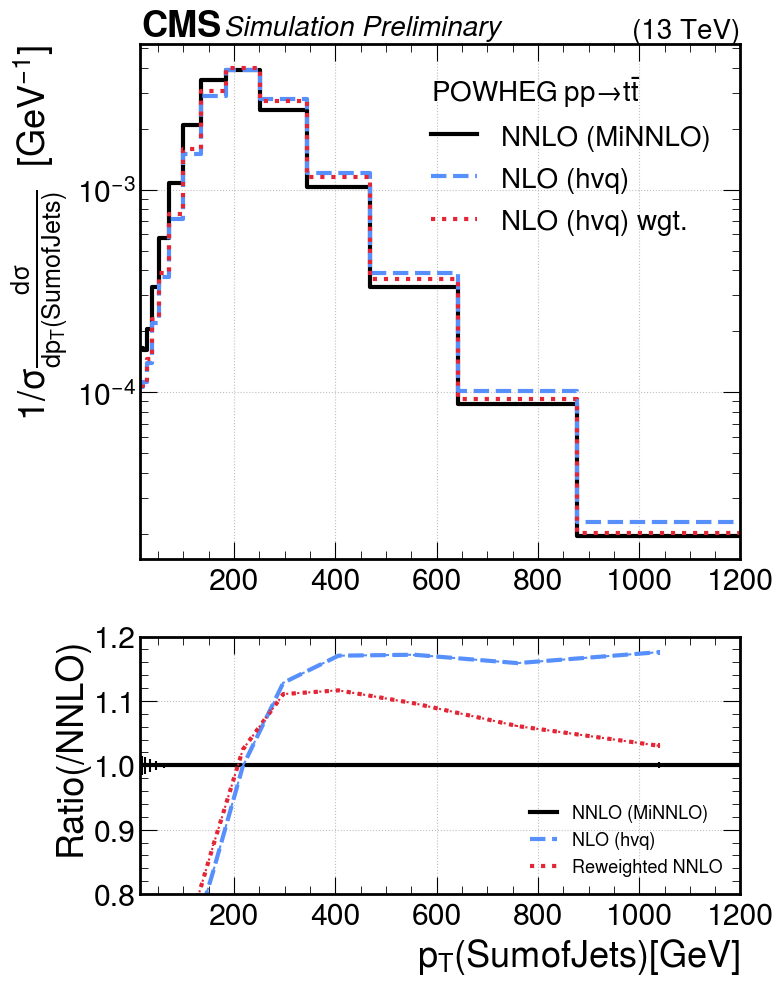

In [ ]:
# sum of jets (incl b jets) pt per event

X0_jet_pt_sums = []
for event in X0_jet:
    X0_jet_pt_sums.append(np.sum(event[:,0]))

X1_jet_pt_sums = []
for event in X1_jet:
    X1_jet_pt_sums.append(np.sum(event[:,0]))

    
print(f'{np.shape(X0_jet_pt_sums) = }')
print(f'{np.shape(X1_jet_pt_sums) = }')


args_jet_sum = [(np.array(X1_jet_pt_sums), X1_wgt, 'NNLO (MiNNLO)'),
                (np.array(X0_jet_pt_sums), X0_wgt, 'NLO (hvq)'),
                (np.array(X0_jet_pt_sums), dctr_rwgt, 'NLO (hvq) wgt.')]

log_bins = np.logspace(np.log10(15), np.log10(1200), 15)
lin_bins = np.linspace(15, 800, 15)

DCTR.plot_ratio_cms(args_jet_sum, bins = log_bins, y_scale = 'log', part_label='Sum of Jets', ratio_ylim=(0.8, 1.2))

